# Spam Email Assessment

## 1. Project Overview

The goal of this project is to classify emails as spam or not spam using various machine learning models. The data used for this analysis is sourced from https://www.kaggle.com/datasets/mfaisalqureshi/spam-email

## 2. Imports

In [1]:
import pandas as pd
import numpy as np
import time
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 3. Pipeline

In [2]:
def load_data(filepath):
    """Load dataset from the provided file path."""
    return pd.read_csv(filepath)

def preprocess_data(df):
    """Preprocess the data by converting to lowercase, removing punctuation, tokenizing, and removing stopwords."""
    df['Spam'] = df['Category'].map({'spam': 1, 'ham': 0})
    df['Message'] = df['Message'].str.lower().str.replace(f"[{string.punctuation}]", " ", regex=True)
    df['Message'] = df['Message'].apply(word_tokenize)
    stop_words = set(stopwords.words('english'))
    df['Message'] = df['Message'].apply(lambda x: [word for word in x if word not in stop_words])
    df['Message'] = df['Message'].apply(lambda x: ' '.join(x))
    return df

def extract_features_and_target(df):
    """Extract features and target variable for model training."""
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['Message'])
    y = df['Spam']
    return X, y

def train_models(X_train, y_train):
    """Train multiple models and return a dictionary of trained models."""
    models = {
        'Logistic Regression': LogisticRegression(),
        'Naive Bayes': MultinomialNB(),
        'SVM': SVC(),
    }
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model
    return trained_models

def evaluate_model(model, X_test, y_test):
    """Evaluate the model performance and return evaluation metrics."""
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    return accuracy, conf_matrix, class_report

def visualize_results(results):
    """Visualize the results for accuracy and confusion matrix."""
    accuracies = [result['accuracy'] for result in results.values()]
    model_names = list(results.keys())
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=model_names, y=accuracies)
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.show()

    num_models = len(results)
    num_rows = (num_models + 1) // 2
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 6))
    axes = axes.flatten()
    
    for i, (name, result) in enumerate(results.items()):
        ax = axes[i]
        sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'Confusion Matrix for {name}')
        ax.set_ylabel('Actual')
        ax.set_xlabel('Predicted')
    
    for j in range(num_models, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def ensemble_model(X_train, y_train, X_test, y_test):
    """Train and evaluate an ensemble model using VotingClassifier."""
    ensemble = VotingClassifier(estimators=[
        ('nb', MultinomialNB()),
        ('lr', LogisticRegression()),
        ('svm', SVC())
    ], voting='hard')
    start_time = time.time()
    ensemble.fit(X_train, y_train)
    y_pred_ensemble = ensemble.predict(X_test)
    end_time = time.time()
    
    accuracy = accuracy_score(y_test, y_pred_ensemble)
    conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
    class_report = classification_report(y_test, y_pred_ensemble)
    runtime = end_time - start_time
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'runtime': runtime
    }

## 4. Execution

In [3]:
# Main workflow
spam_df = load_data('./datasets/spam.csv')
spam_df = preprocess_data(spam_df)
X, y = extract_features_and_target(spam_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train models
trained_models = train_models(X_train, y_train)

# Evaluate models
results = {}
for name, model in trained_models.items():
    accuracy, conf_matrix, class_report = evaluate_model(model, X_test, y_test)
    results[name] = {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }

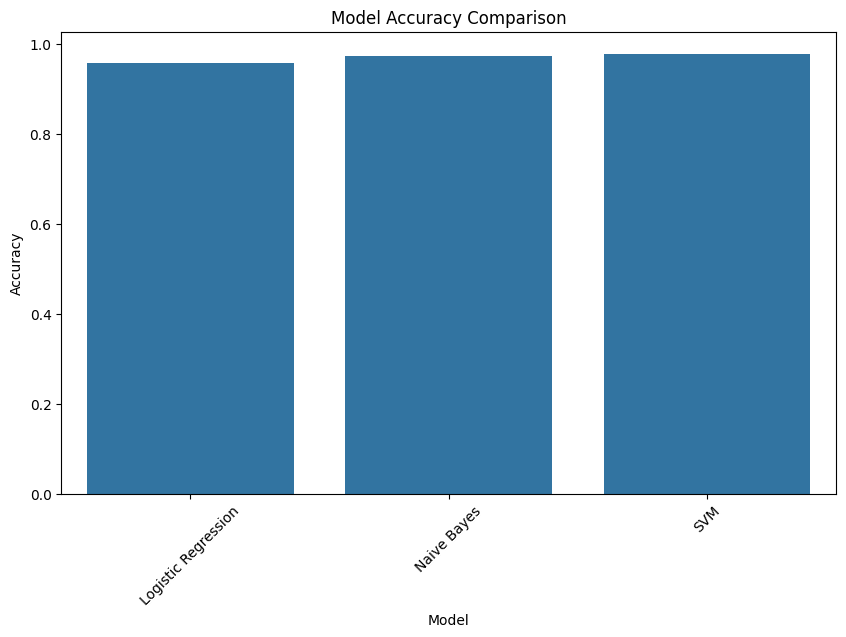

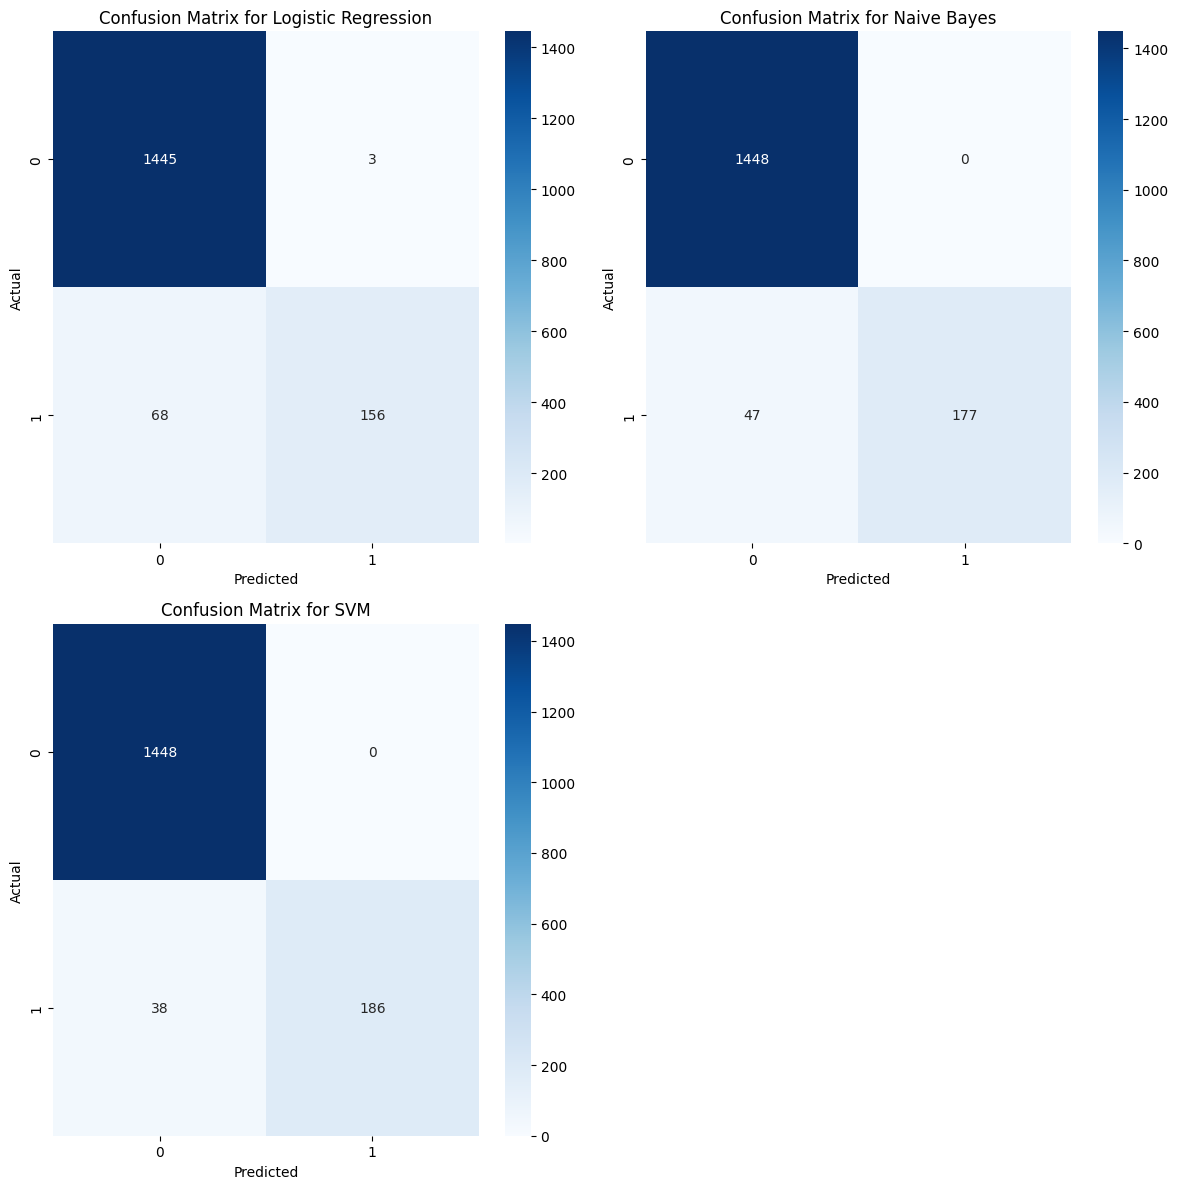

In [4]:
# Visualize results
visualize_results(results)

In [5]:
# Ensemble model evaluation
ensemble_results = ensemble_model(X_train, y_train, X_test, y_test)
print("Ensemble Model:")
print(f"Accuracy: {ensemble_results['accuracy']:.4f}")
print(f"Runtime: {ensemble_results['runtime']:.4f} seconds")
print(f"Confusion Matrix:\n{ensemble_results['confusion_matrix']}")
print(f"Classification Report:\n{ensemble_results['classification_report']}")

Ensemble Model:
Accuracy: 0.9713
Runtime: 5.5104 seconds
Confusion Matrix:
[[1448    0]
 [  48  176]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1448
           1       1.00      0.79      0.88       224

    accuracy                           0.97      1672
   macro avg       0.98      0.89      0.93      1672
weighted avg       0.97      0.97      0.97      1672



In [6]:
# Comparison with the Best Individual Model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model_accuracy = results[best_model_name]['accuracy']

print(f"\nBest Individual Model: {best_model_name}")
print(f"Accuracy: {best_model_accuracy:.4f}")


Best Individual Model: SVM
Accuracy: 0.9773


In [7]:
# Compare the ensemble model's accuracy with the best individual model's accuracy
if ensemble_results['accuracy'] > best_model_accuracy:
    print("The ensemble model outperformed the best individual model.")
else:
    print("The best individual model outperformed the ensemble model.")

print("\nFinal Comparison:")
print(f"Best Individual Model Accuracy: {best_model_accuracy:.4f}")
print(f"Ensemble Model Accuracy: {ensemble_results['accuracy']:.4f}")

The best individual model outperformed the ensemble model.

Final Comparison:
Best Individual Model Accuracy: 0.9773
Ensemble Model Accuracy: 0.9713
